In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)

plt.rcParams["figure.dpi"] = 120

In [ ]:
!pip install tqdm
from tqdm import tqdm
import time
from concurrent.futures import ThreadPoolExecutor, as_completed

In [ ]:
def timeit(func):
    """Decorator for timing functions"""
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        elapsed = time.time() - start
        return result, elapsed
    return wrapper


In [ ]:
BASE_DIR = "/content/drive/MyDrive/CMPE 593/datasets"

NTHU_TEST = os.path.join(BASE_DIR, "processed_datasets/NTHU-DDD/test")
DDD_DIR = os.path.join(BASE_DIR, "Driver Drowsiness Dataset (DDD)")

In [ ]:
MODELS = {
    "resnet50v2" : os.path.join(BASE_DIR, "processed_datasets/NTHU-DDD/resnet50v2_final.keras"),
    "mobilenetv2": os.path.join(BASE_DIR, "processed_datasets/NTHU-DDD/mobilenetv2_nthu_ddd_final.keras"),
    "efficientnetb0": os.path.join(BASE_DIR, "processed_datasets/NTHU-DDD/efficientnetb0_final.keras"),
    "nasnetmobile": os.path.join(BASE_DIR, "processed_datasets/NTHU-DDD/nasnetmobile_nthu_ddd_final.keras"),
}

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 128
CLASS_NAMES = ["notdrowsy", "drowsy"]

In [ ]:
print("Models found:")
for k, v in MODELS.items():
    print(f" - {k}: {v}")

Models found:
 - resnet50v2: /content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/resnet50v2_final.keras
 - mobilenetv2: /content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/mobilenetv2_nthu_ddd_final.keras
 - efficientnetb0: /content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/efficientnetb0_final.keras
 - nasnetmobile: /content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/nasnetmobile_nthu_ddd_final.keras


In [ ]:
def load_dataset(directory):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        class_names=CLASS_NAMES,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )
    return ds.prefetch(tf.data.AUTOTUNE)

test_nthu = load_dataset(NTHU_TEST)
test_ddd  = load_dataset(DDD_DIR)

Found 9979 files belonging to 2 classes.
Found 41794 files belonging to 2 classes.


DDD class counts: {'notdrowsy': 19446, 'drowsy': 22348}


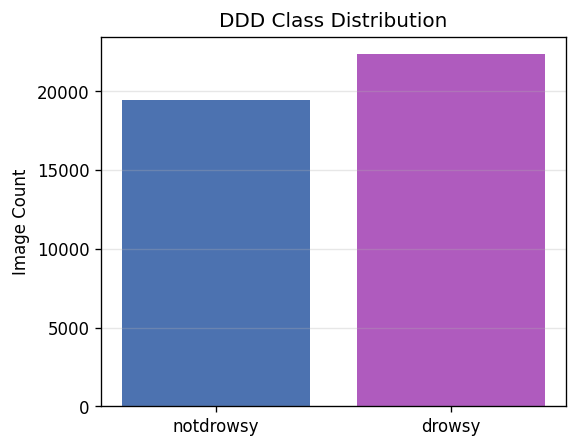

In [ ]:
from collections import Counter

def count_images_by_class(directory):
    counts = {}
    for cls in CLASS_NAMES:
        folder = os.path.join(directory, cls)
        if os.path.exists(folder):
            counts[cls] = len(os.listdir(folder))
        else:
            counts[cls] = 0
    return counts

ddd_counts = count_images_by_class(DDD_DIR)
print("DDD class counts:", ddd_counts)

plt.figure(figsize=(5,4))
plt.bar(ddd_counts.keys(), ddd_counts.values(), color=["#4C72B0", "#AF5BBE"])
plt.title("DDD Class Distribution")
plt.ylabel("Image Count")
plt.grid(axis="y", alpha=0.3)
plt.show()

In [ ]:
@timeit
def evaluate_model(model, dataset, model_name):

    # Gather ground truth
    y_true = []
    for _, labels in dataset:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)

    # Predict with tqdm progress bar (NO workers argument)
    all_probs = []
    for batch in tqdm(dataset, desc=f"Predicting {model_name}", ncols=100):
        imgs, _ = batch
        probs = model.predict(
            imgs,
            verbose=0
        ).ravel()
        all_probs.extend(probs)

    y_prob = np.array(all_probs)
    y_pred = (y_prob >= 0.5).astype(int)

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "auc": roc_auc_score(y_true, y_prob),
    }

    return metrics, y_true, y_pred, y_prob

Evaluate All Models on Both Datasets

In [ ]:
# ------------------------------------------------
# PARALLEL MODEL EVALUATION
# ------------------------------------------------

results_nthu = {}
results_ddd  = {}
predictions_cache = {}

def evaluate_both_datasets(model_name, model_path):
    model = keras.models.load_model(model_path)

    # NTHU
    (m_nthu, y_t_n, y_p_n, y_pr_n), t_nthu = evaluate_model(model, test_nthu, model_name)

    # DDD
    (m_ddd, y_t_d, y_p_d, y_pr_d), t_ddd = evaluate_model(model, test_ddd, model_name)

    return {
        "model_name": model_name,
        "metrics_nthu": m_nthu,
        "metrics_ddd": m_ddd,
        "pred_nthu": (y_t_n, y_p_n, y_pr_n),
        "pred_ddd": (y_t_d, y_p_d, y_pr_d),
        "time_nthu": t_nthu,
        "time_ddd": t_ddd,
        "time_total": t_nthu + t_ddd
    }

# Run models in parallel threads
futures = []
with ThreadPoolExecutor(max_workers=4) as executor:
    for name, path in MODELS.items():
        futures.append(executor.submit(evaluate_both_datasets, name, path))

for future in as_completed(futures):
    output = future.result()
    name = output["model_name"]

    results_nthu[name] = output["metrics_nthu"]
    results_ddd[name]  = output["metrics_ddd"]

    predictions_cache[name] = {
        "nthu": output["pred_nthu"],
        "ddd":  output["pred_ddd"]
    }

    print(f"\n===== FINISHED {name.upper()} =====")
    print(f"NTHU time: {output['time_nthu']:.2f} sec")
    print(f"DDD time : {output['time_ddd']:.2f} sec")
    print(f"TOTAL    : {output['time_total']:.2f} sec")


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
Predicting mobilenetv2:   0%|                                                | 0/78 [00:00<?, ?it/s]

Predicting mobilenetv2:   8%|███                                     | 6/78 [00:05<00:35,  2.02it/s]

Predicting mobilenetv2:   9%|███▌                                    | 7/78 [00:05<00:28,  2.53it/s]

Predicting mobilenetv2:  10%|████                                    | 8/78 [00:06<00:22,  3.10it/s]

Predicting mobilenetv2:  12%|████▌                                   | 9/78 [00:06<00:18,  3.67it/s]

Predicting mobilenetv2:  13%|█████                                  | 10/78 [00:06<00:17,  3.91it/s]

Predicting efficientnetb0:   6%|██▎                                  | 5/78 [00:05<00:40,  1.79it/s]

Predicting e


===== FINISHED EFFICIENTNETB0 =====
NTHU time: 101.00 sec
DDD time : 853.45 sec
TOTAL    : 954.44 sec

===== FINISHED NASNETMOBILE =====
NTHU time: 105.23 sec
DDD time : 842.30 sec
TOTAL    : 947.53 sec

===== FINISHED MOBILENETV2 =====
NTHU time: 98.46 sec
DDD time : 857.71 sec
TOTAL    : 956.16 sec

===== FINISHED RESNET50V2 =====
NTHU time: 108.18 sec
DDD time : 851.54 sec
TOTAL    : 959.71 sec


,Model,NTHU Time (sec),DDD Time (sec),Total Time (sec),Speed NTHU (img/sec),Speed DDD (img/sec)
3,nasnetmobile,105.23,842.30,947.53,94.83,49.62
2,efficientnetb0,101.00,853.45,954.44,98.80,48.97
1,mobilenetv2,98.46,857.71,956.16,101.35,48.73
0,resnet50v2,108.18,851.54,959.71,92.25,49.08


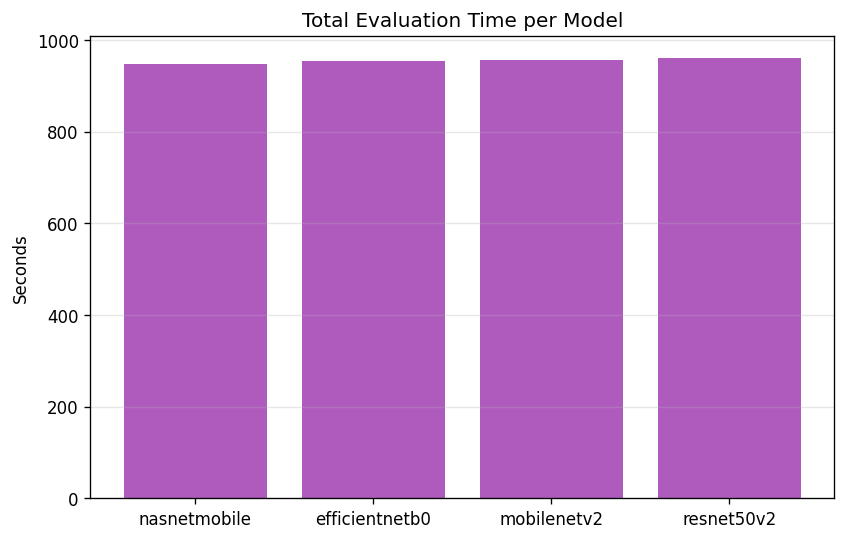

In [ ]:
timing_data = []

# Extract timing info for each model from futures
for future in futures:
    out = future.result()
    timing_data.append({
        "Model": out["model_name"],
        "NTHU Time (sec)": round(out["time_nthu"], 2),
        "DDD Time (sec)": round(out["time_ddd"], 2),
        "Total Time (sec)": round(out["time_total"], 2),
        "Speed NTHU (img/sec)": round(len(out["pred_nthu"][0]) / out["time_nthu"], 2),
        "Speed DDD (img/sec)": round(len(out["pred_ddd"][0]) / out["time_ddd"], 2),
    })

timing_df = pd.DataFrame(timing_data)
timing_df = timing_df.sort_values("Total Time (sec)")

display(
    timing_df.style
        .background_gradient(subset=["Total Time (sec)"], cmap="Reds")
        .background_gradient(subset=["Speed NTHU (img/sec)", "Speed DDD (img/sec)"], cmap="Greens")
        .highlight_max(subset=["Speed NTHU (img/sec)"], color="#b3ffb3")
        .highlight_max(subset=["Speed DDD (img/sec)"], color="#b3ffb3")
        .format({
            "NTHU Time (sec)": "{:.2f}",
            "DDD Time (sec)": "{:.2f}",
            "Total Time (sec)": "{:.2f}",
            "Speed NTHU (img/sec)": "{:.2f}",
            "Speed DDD (img/sec)": "{:.2f}",
        })
)

# Optional: also plot total time
plt.figure(figsize=(8,5))
plt.bar(timing_df["Model"], timing_df["Total Time (sec)"], color="#AF5BBE")
plt.title("Total Evaluation Time per Model")
plt.ylabel("Seconds")
plt.grid(axis="y", alpha=0.3)
plt.show()

Confusion Matrix Plots

In [ ]:
def plot_dual_cm(model_name):
    y_t_n, y_p_n, _ = predictions_cache[model_name]["nthu"]
    y_t_d, y_p_d, _ = predictions_cache[model_name]["ddd"]

    fig, axes = plt.subplots(1,2, figsize=(10,4))

    sns.heatmap(confusion_matrix(y_t_n, y_p_n), annot=True, fmt="d",
                cmap="Blues", ax=axes[0], xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    axes[0].set_title(f"{model_name} - NTHU")

    sns.heatmap(confusion_matrix(y_t_d, y_p_d), annot=True, fmt="d",
                cmap="Purples", ax=axes[1], xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    axes[1].set_title(f"{model_name} - DDD")

    plt.tight_layout()
    plt.show()


Plotting ROC curves for: resnet50v2


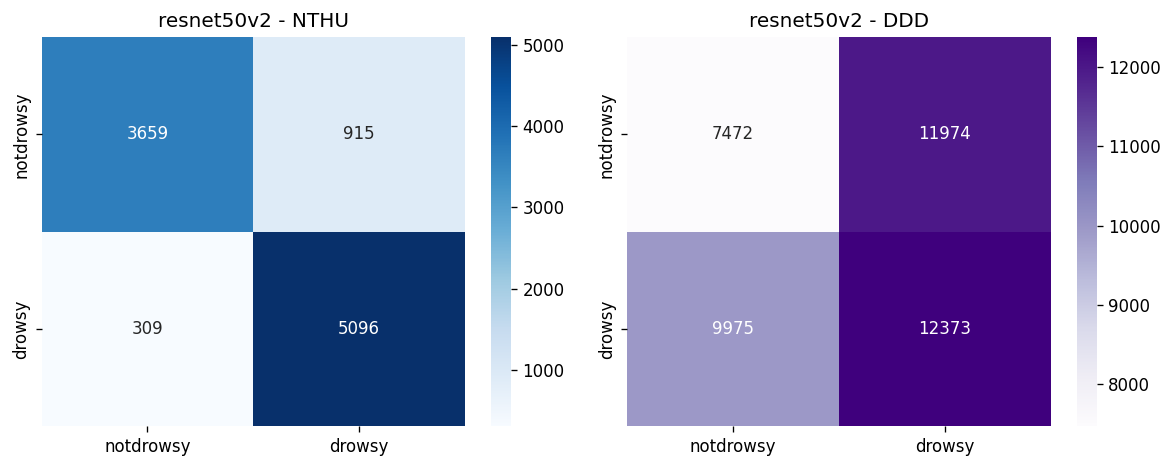


Plotting ROC curves for: mobilenetv2


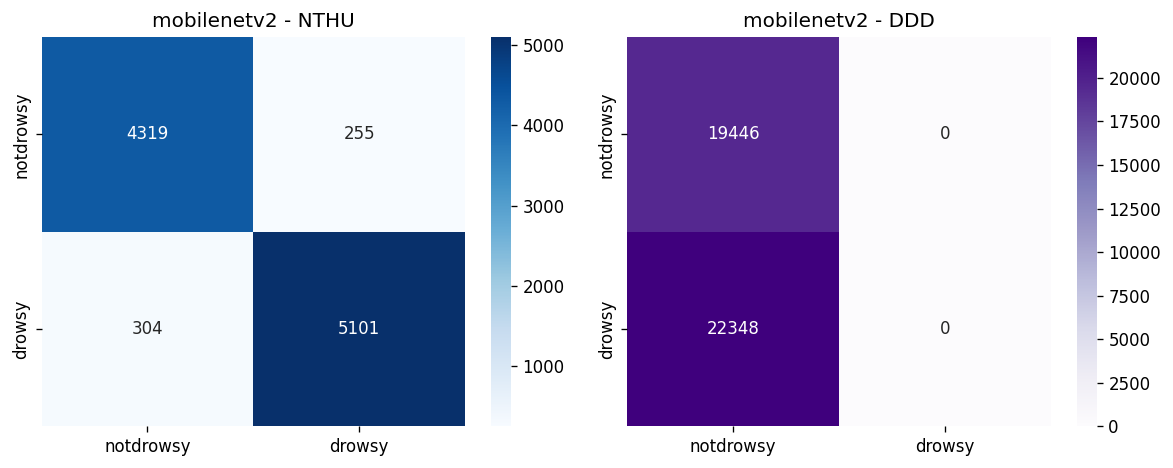


Plotting ROC curves for: efficientnetb0


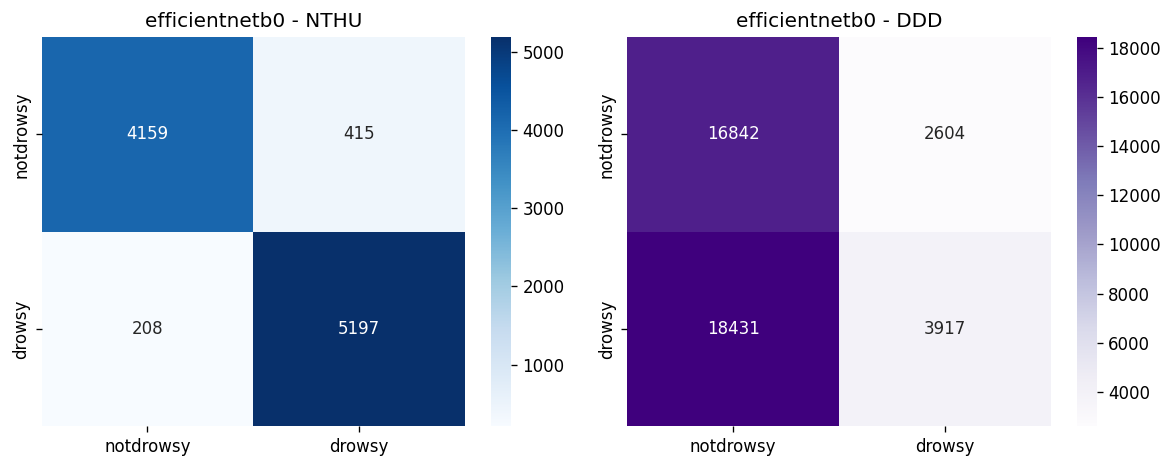


Plotting ROC curves for: nasnetmobile


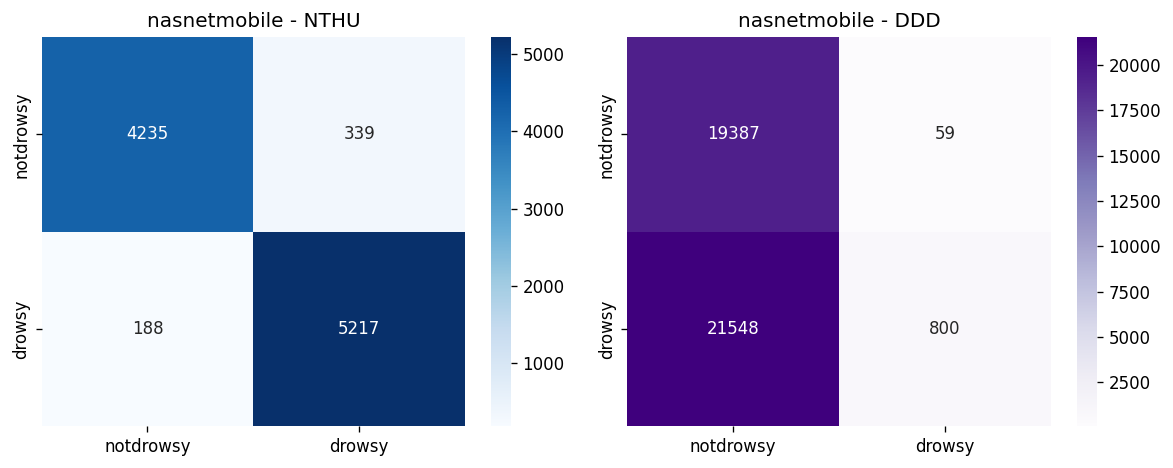

In [24]:
for model_name in MODELS.keys():
    print(f"\nPlotting ROC curves for: {model_name}")
    plot_dual_cm(model_name)

ROC Curves

In [ ]:
def plot_dual_roc(model_name):
    y_t_n, _, y_pr_n = predictions_cache[model_name]["nthu"]
    y_t_d, _, y_pr_d = predictions_cache[model_name]["ddd"]

    plt.figure(figsize=(12,5))

    # NTHU
    plt.subplot(1,2,1)
    fpr, tpr, _ = roc_curve(y_t_n, y_pr_n)
    auc_val = roc_auc_score(y_t_n, y_pr_n)
    plt.plot(fpr, tpr, label=f"AUC={auc_val:.3f}")
    plt.plot([0,1],[0,1],"--")
    plt.title(f"{model_name} - NTHU")
    plt.grid(True)
    plt.legend()

    # DDD
    plt.subplot(1,2,2)
    fdr, tdr, _ = roc_curve(y_t_d, y_pr_d)
    auc_val = roc_auc_score(y_t_d, y_pr_d)
    plt.plot(fdr, tdr, label=f"AUC={auc_val:.3f}", color="purple")
    plt.plot([0,1],[0,1],"--")
    plt.title(f"{model_name} - DDD")
    plt.grid(True)
    plt.legend()

    plt.show()


Plotting ROC curves for: resnet50v2


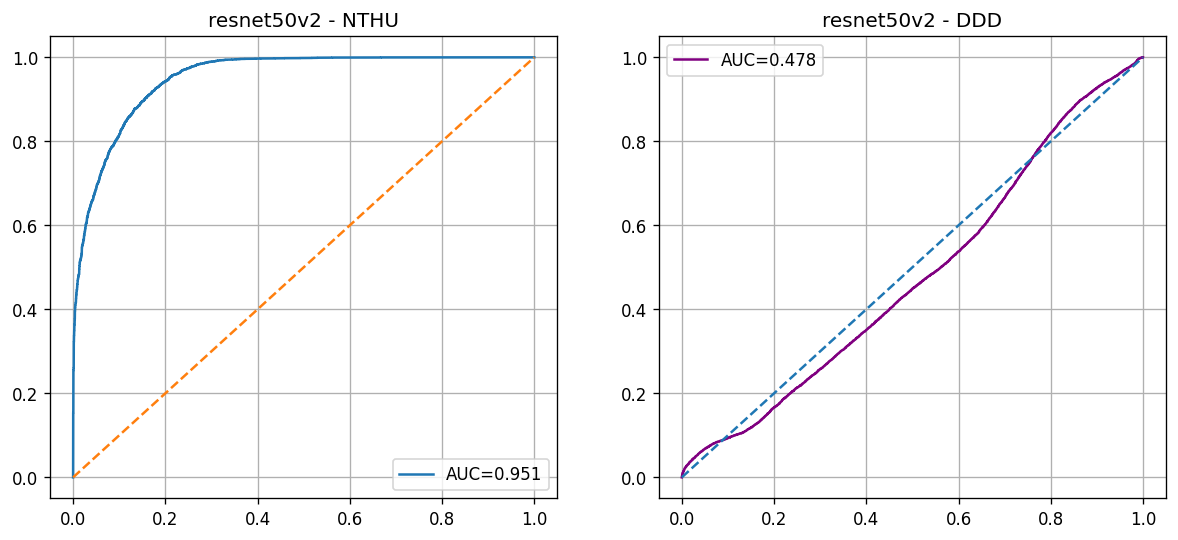


Plotting ROC curves for: mobilenetv2


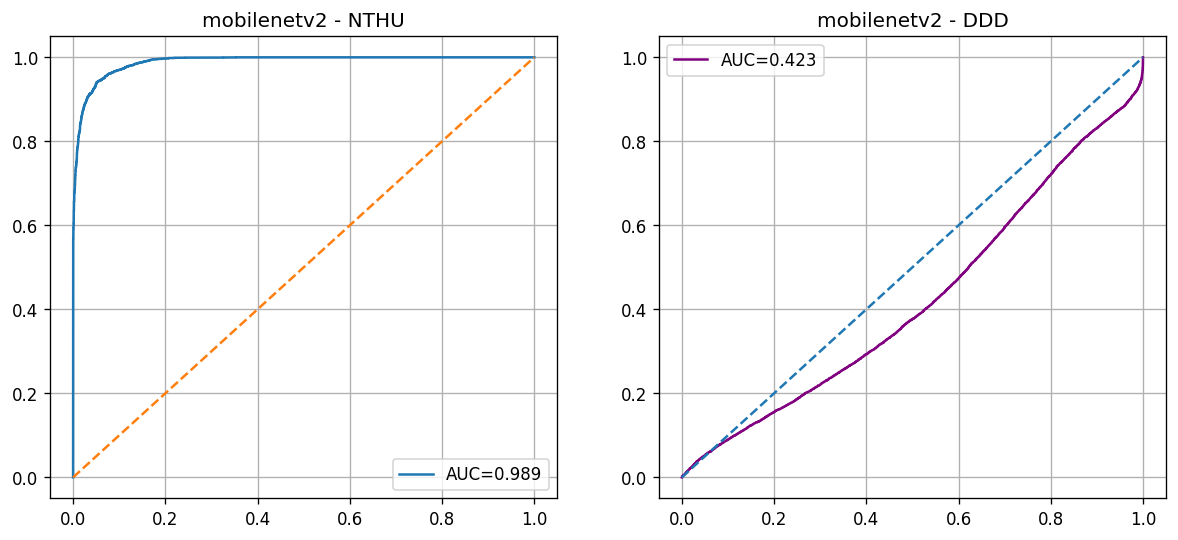


Plotting ROC curves for: efficientnetb0


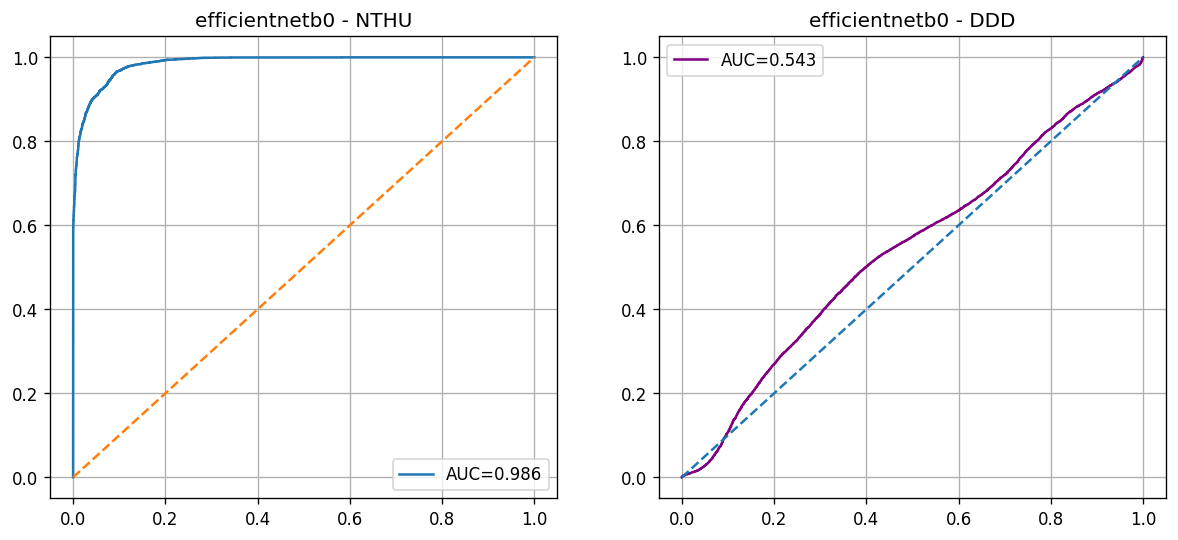


Plotting ROC curves for: nasnetmobile


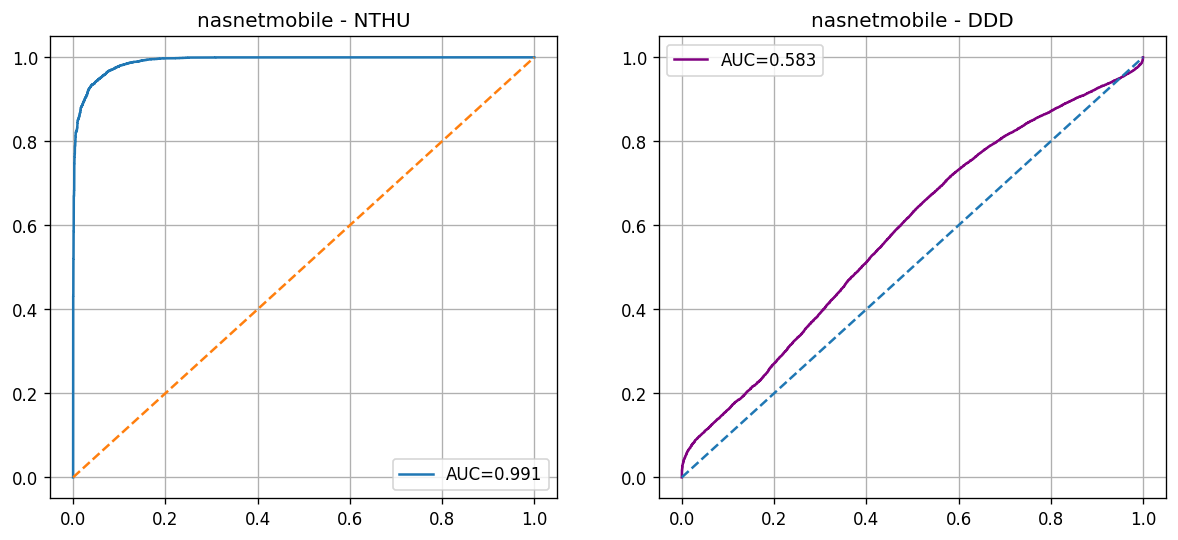

In [23]:
for model_name in MODELS.keys():
    print(f"\nPlotting ROC curves for: {model_name}")
    plot_dual_roc(model_name)

Comparison Bar Plots (per metric)

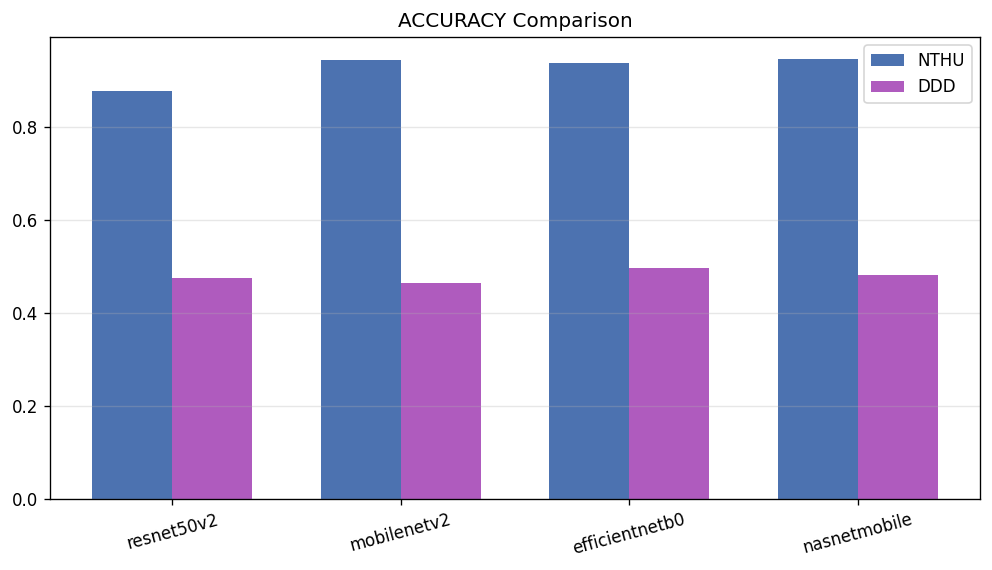

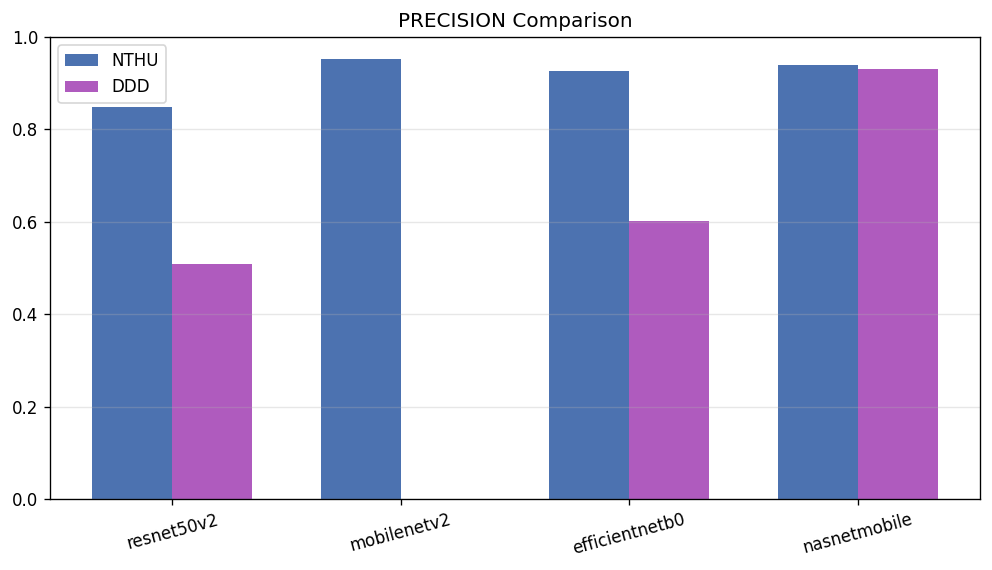

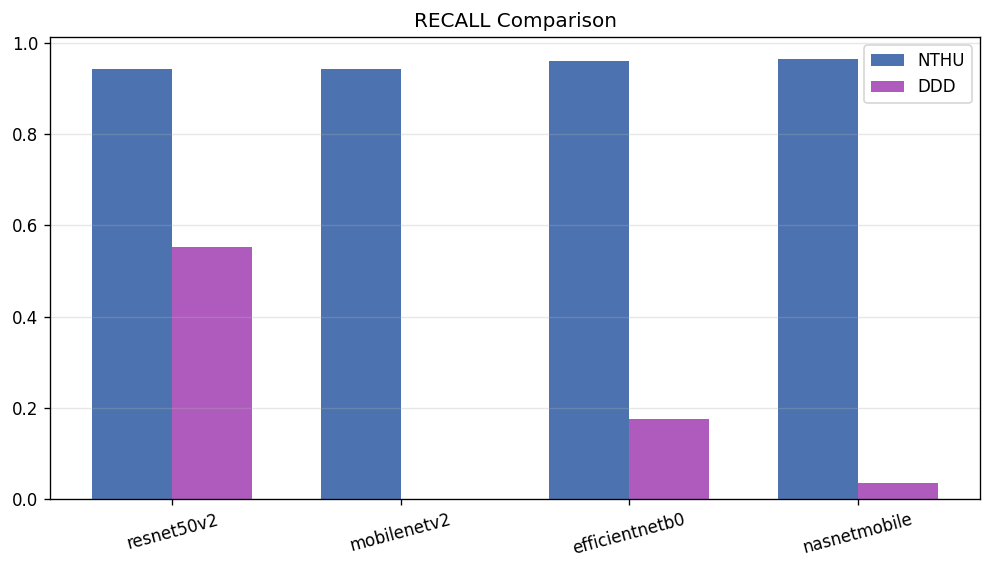

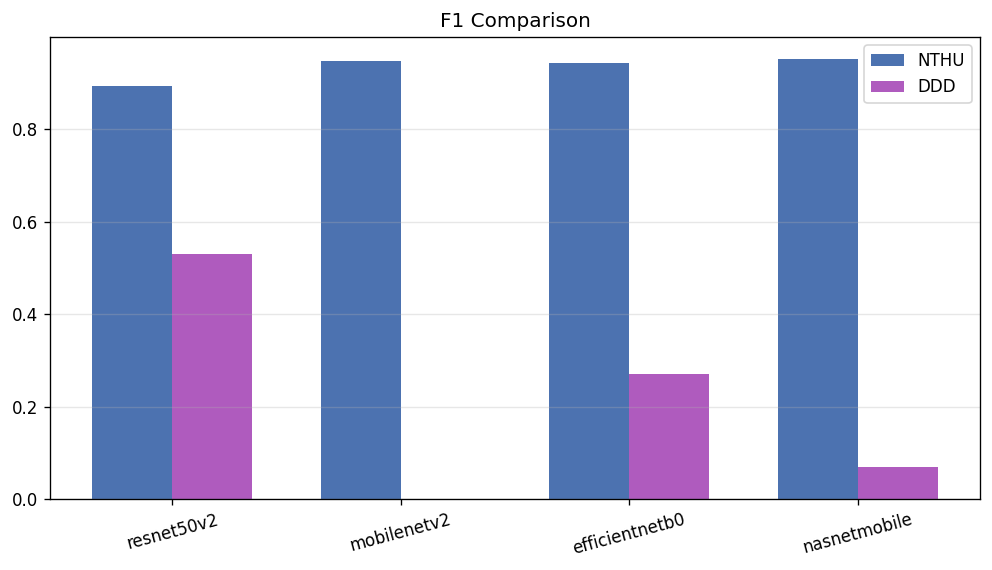

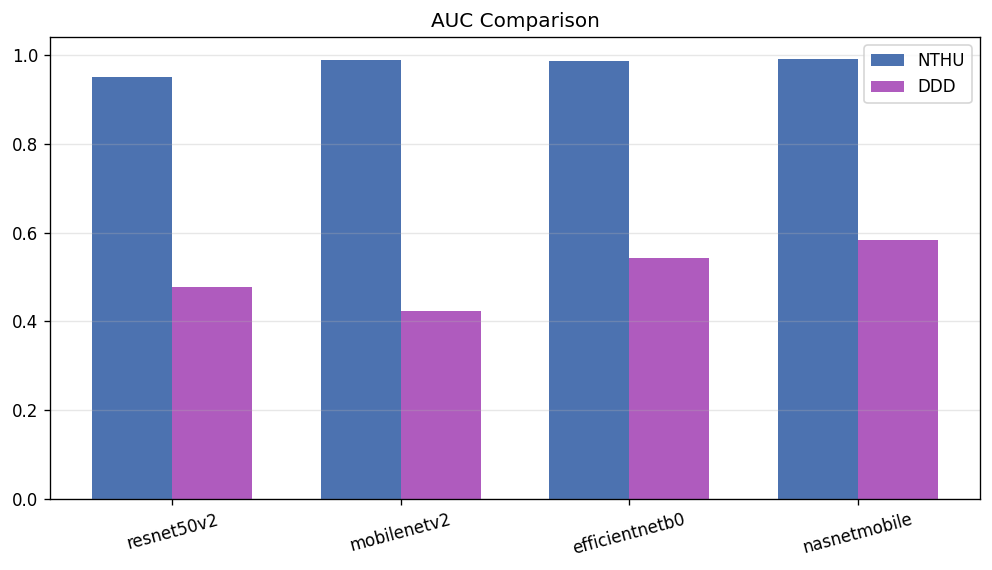

In [ ]:
metrics = ["accuracy", "precision", "recall", "f1", "auc"]

for metric in metrics:
    plt.figure(figsize=(10,5))

    nthu_vals = [results_nthu[m][metric] for m in MODELS]
    ddd_vals  = [results_ddd[m][metric] for m in MODELS]

    x = np.arange(len(MODELS))
    width = 0.35

    plt.bar(x - width/2, nthu_vals, width, label="NTHU", color="#4C72B0")
    plt.bar(x + width/2, ddd_vals,  width, label="DDD",  color="#AF5BBE")

    plt.xticks(x, MODELS.keys(), rotation=15)
    plt.title(f"{metric.upper()} Comparison")
    plt.grid(axis="y", alpha=0.3)
    plt.legend()
    plt.show()


Generalization Drop Plots (Δ)

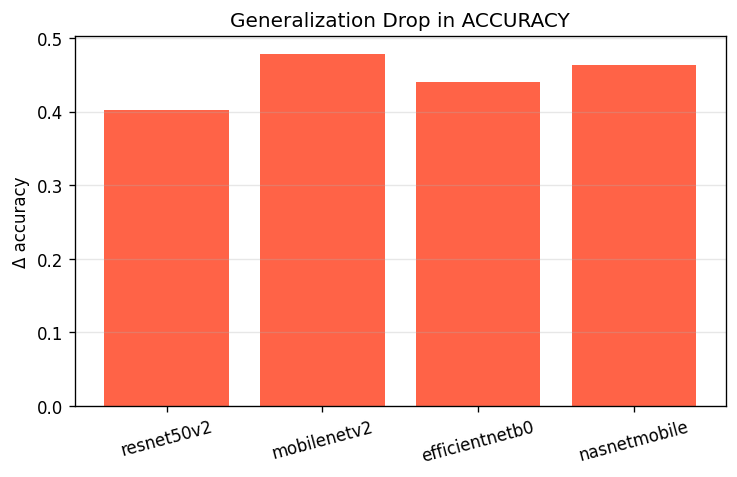

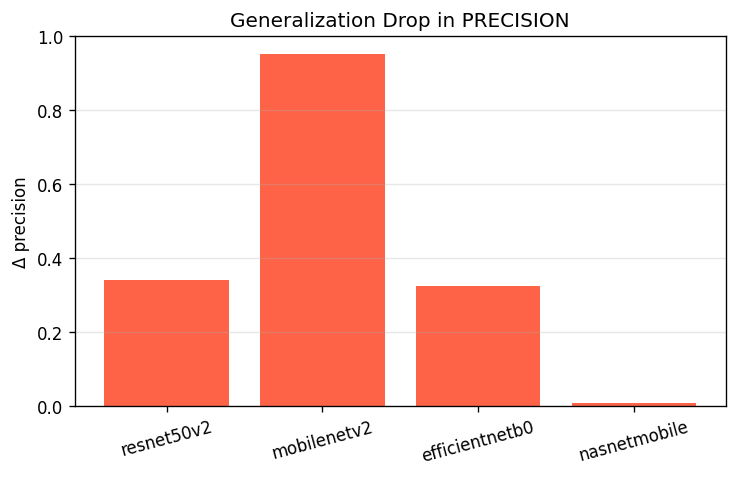

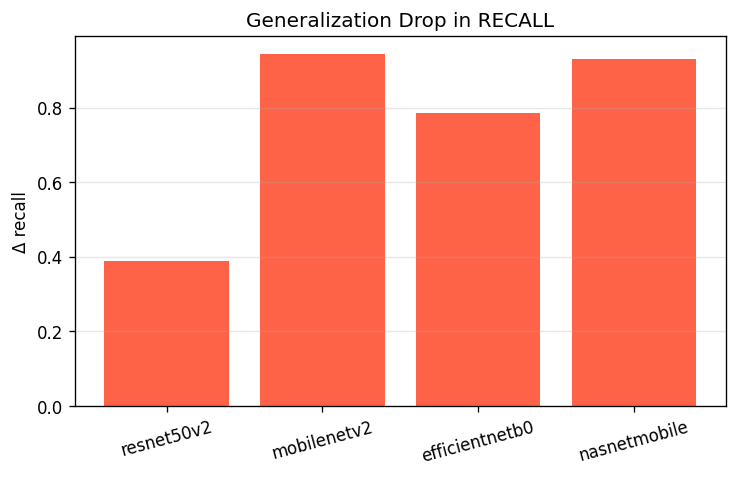

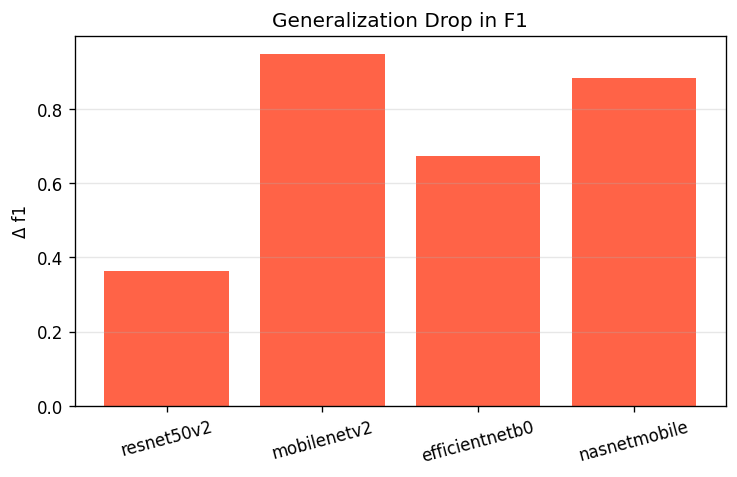

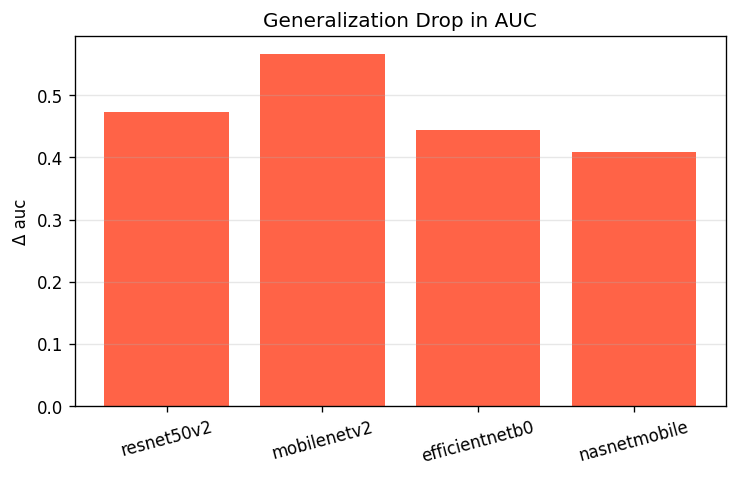

In [ ]:
for metric in metrics:
    drops = [results_nthu[m][metric] - results_ddd[m][metric] for m in MODELS]

    plt.figure(figsize=(7,4))
    plt.bar(MODELS.keys(), drops, color="tomato")
    plt.ylabel(f"Δ {metric}")
    plt.title(f"Generalization Drop in {metric.upper()}")
    plt.grid(axis="y", alpha=0.3)
    plt.xticks(rotation=15)
    plt.show()


Multi-Metric Summary Plot

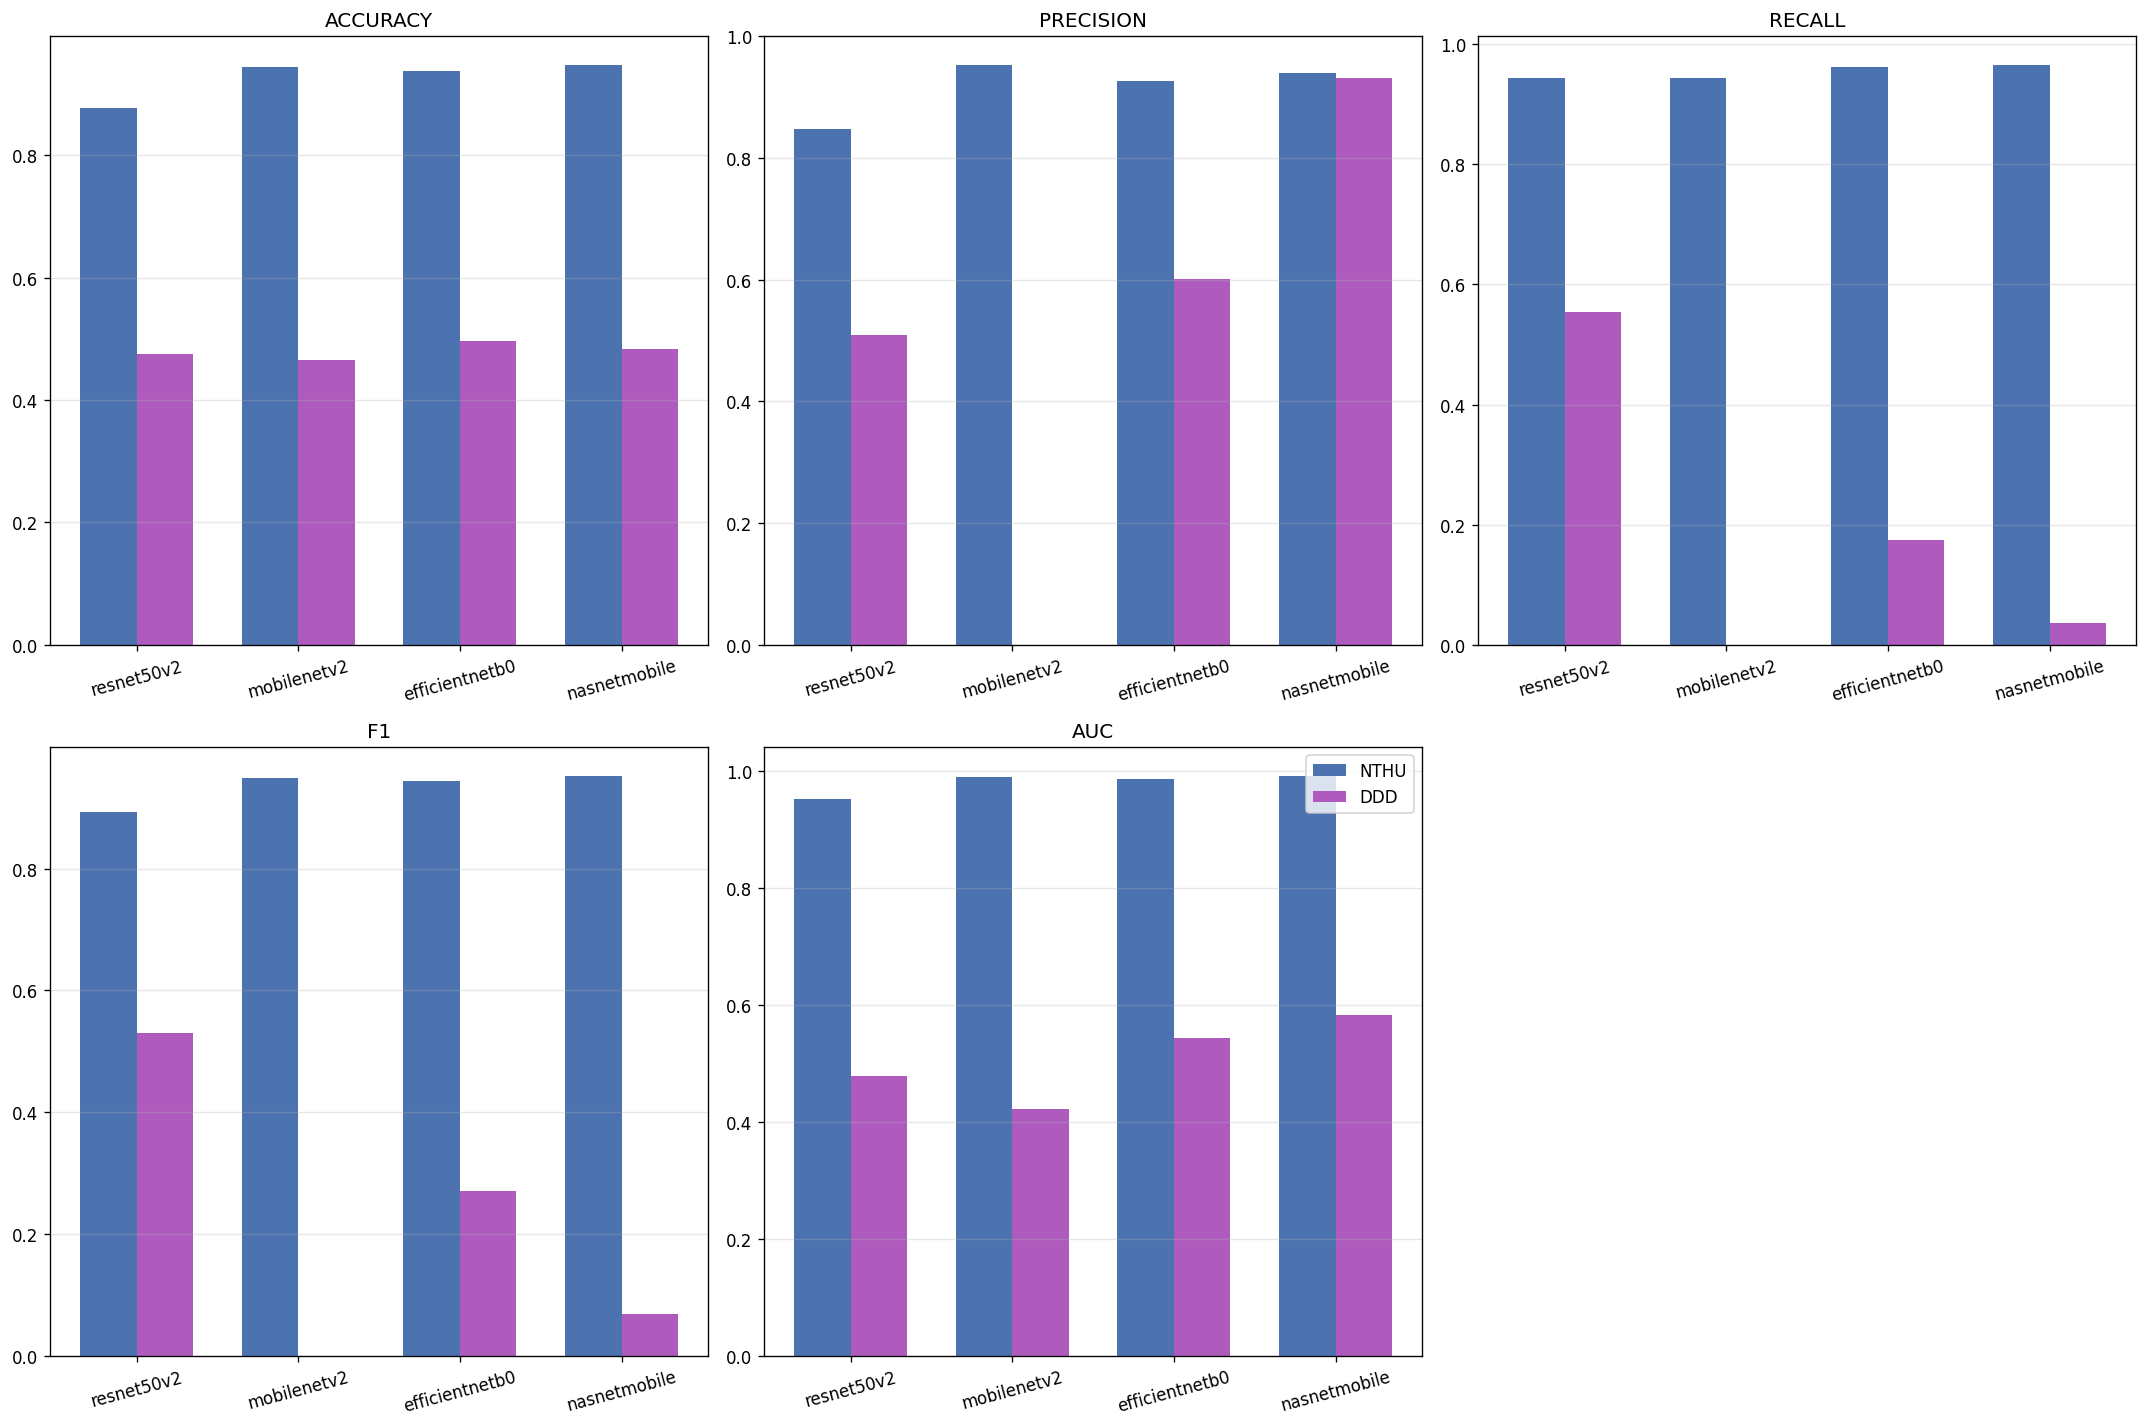

In [ ]:
plt.figure(figsize=(18,12))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)

    nthu_vals = [results_nthu[m][metric] for m in MODELS]
    ddd_vals  = [results_ddd[m][metric] for m in MODELS]

    x = np.arange(len(MODELS))
    width = 0.35

    plt.bar(x - width/2, nthu_vals, width, label="NTHU", color="#4C72B0")
    plt.bar(x + width/2, ddd_vals,  width, label="DDD",  color="#AF5BBE")

    plt.xticks(x, MODELS.keys(), rotation=15)
    plt.title(metric.upper())
    plt.grid(axis="y", alpha=0.3)

plt.legend()
plt.tight_layout()
plt.show()


Radar Charts

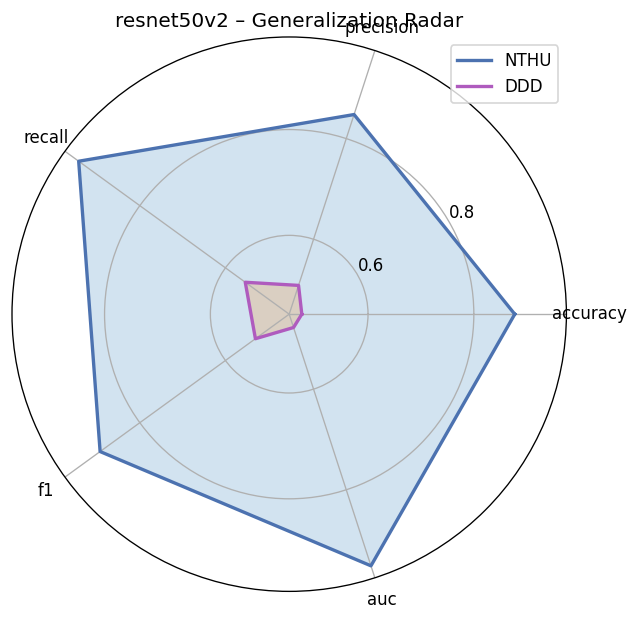

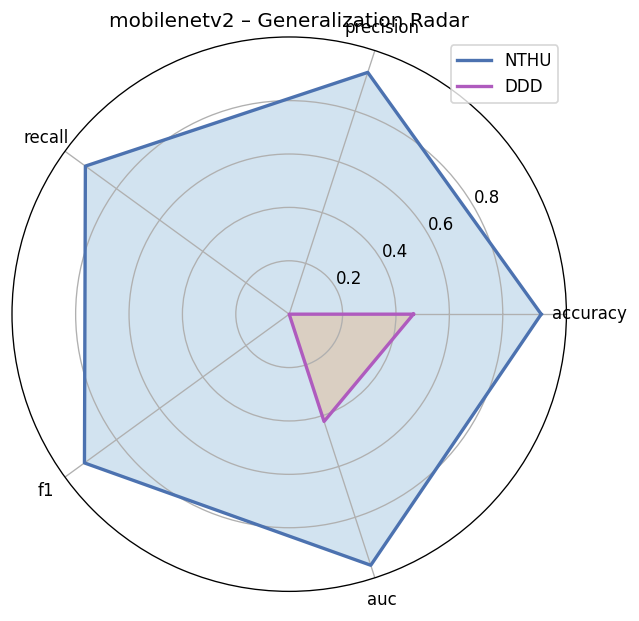

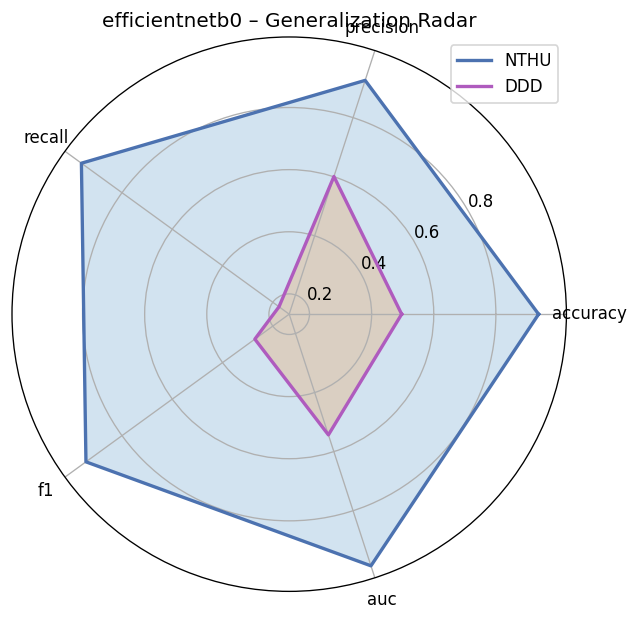

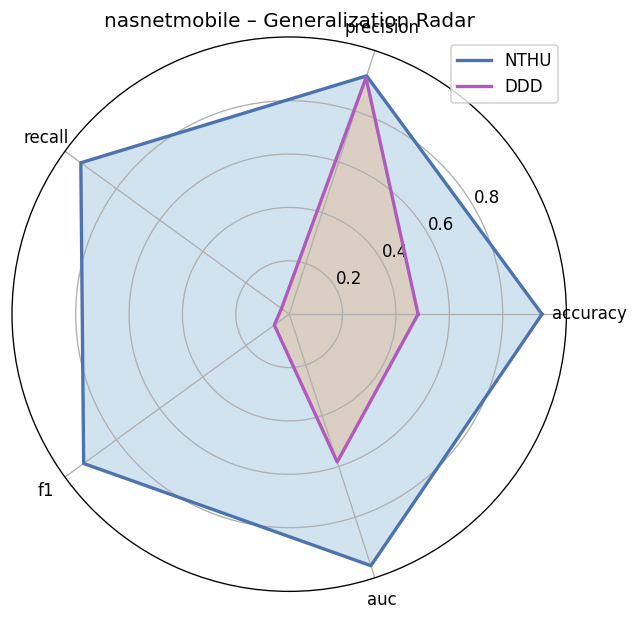

In [ ]:
from math import pi

def plot_radar(model_name):
    nthu = results_nthu[model_name]
    ddd  = results_ddd[model_name]

    labels = metrics
    angles = [n/float(len(labels)) * 2 * pi for n in range(len(labels))]
    angles += angles[:1]

    # values
    n_vals = [nthu[m] for m in labels] + [nthu[labels[0]]]
    d_vals = [ddd[m]  for m in labels] + [ddd[labels[0]]]

    plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)

    plt.xticks(angles[:-1], labels)
    ax.set_rlabel_position(30)
    plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"])

    ax.plot(angles, n_vals, linewidth=2, label="NTHU", color="#4C72B0")
    ax.fill(angles, n_vals, alpha=0.2)

    ax.plot(angles, d_vals, linewidth=2, label="DDD", color="#AF5BBE")
    ax.fill(angles, d_vals, alpha=0.2)

    plt.title(f"{model_name} – Generalization Radar")
    plt.legend(loc="upper right")
    plt.show()


for m in MODELS:
    plot_radar(m)


Final Summary Tables

In [22]:
df_nthu = pd.DataFrame(results_nthu).T
df_ddd  = pd.DataFrame(results_ddd).T

print("=== NTHU-DDD Results ===")
display(df_nthu.style.background_gradient(cmap="Blues"))

print("=== DDD Results ===")
display(df_ddd.style.background_gradient(cmap="Purples"))


=== NTHU-DDD Results ===


,accuracy,precision,recall,f1,auc
efficientnetb0,0.937569,0.926051,0.961517,0.943451,0.986496
nasnetmobile,0.947189,0.938985,0.965217,0.951920,0.990942
mobilenetv2,0.943982,0.952390,0.943756,0.948053,0.988979
resnet50v2,0.877342,0.847779,0.942831,0.892782,0.951142


=== DDD Results ===


,accuracy,precision,recall,f1,auc
efficientnetb0,0.496698,0.600675,0.175273,0.271364,0.543228
nasnetmobile,0.483012,0.931315,0.035797,0.068945,0.582530
mobilenetv2,0.465282,0.000000,0.000000,0.000000,0.422546
resnet50v2,0.474829,0.508194,0.553651,0.529950,0.477525
